# Projet MAP473D : Simulation Moléculaire #
### Barthélémy Bulteau - Smail El Hafdi ###

Imports des libraires nécessaires au projet

In [15]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Représentation graphique de la fonction potentiel $V(x) = \frac{x^4}{4} + \frac{x^3}{3} - \frac{x^2}{2}$ et de ses minimas situés en $x_1 \approx -1.618$ et $x_2 \approx 0.618$.

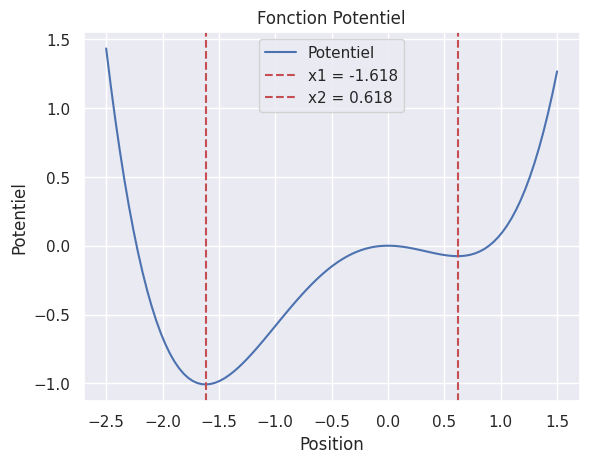

In [143]:
# Fonction potentiel
def V(x):
    return (3*x**4 + 4*x**3 - 6*x**2)/12

# Dérivée
def Vprime(x):
    return x*(x**2 + x - 1)

# Abscisses des minimas
x1 = (-1-np.sqrt(5))/2
x2 = (-1+np.sqrt(5))/2
x0 = x1+0.1

# représentation graphique
x = np.linspace(-2.5, 1.5, 100)
plt.plot(x, V(x), label='Potentiel')
plt.title("Fonction Potentiel")
# plot vertical line for x1 and x2
plt.axvline(x1, color='r', linestyle='--', label=f'x1 = {round(x1, 3)}')
plt.axvline(x2, color='r', linestyle='--', label=f'x2 = {round(x2, 3)}')
plt.xlabel("Position")
plt.ylabel("Potentiel")
plt.legend()
plt.show()

Calcul de la probabilité de l'évènement $R$ par méthode de Monte-Carlo naïve et présentation de la variation de celle-ci en fonction des pramètres $\epsilon$ et $h$.

Proba de R : P(R) = 0.1468


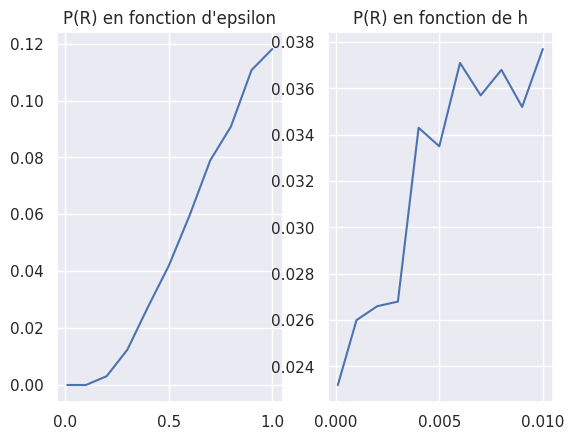

In [144]:
# Calcul de la proba de R={t2 < t1}, P(R) = E(1{t2-t1}) par méthode de Monte-Carlo naïve
def MC_naif(X0, epsilon, h, N):
    E = 0
    global x1
    global x2
    global x0
    sigma = np.sqrt(2*epsilon*h)

    for _ in range(N):
        Xn = X0
        while Xn >= x1 and Xn <= x2:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        if Xn > x2:
            E += 1

    return E/N

# Exemple d'une estimation
print("Proba de R : P(R) = {}".format(MC_naif(x1+0.1, 1, 1, 10000)))

# Variations en fonction d'epsilon
epsilons = [0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
plt.subplot(1, 2, 1)
plt.plot(epsilons, [MC_naif(x1+0.1, e, 0.5, 10000) for e in epsilons])
plt.title("P(R) en fonction d'epsilon")

# Variations en fonction de h
hs = [0.0001, .001, .002, .003, .004, .005, .006, .007, .008, .009, .01]
plt.subplot(1, 2, 2)
plt.plot(hs, [MC_naif(x1+0.1, 1, h, 10000) for h in hs])
plt.title("P(R) en fonction de h")

plt.show()



Utilisation de l'algorithme AMS pour le calcul de la probabilité de l'évènement $R$.

In [18]:
def simulation_trajectoire(X0, h, sigma):
    # simulation d'une trajectoire
    Xn = X0
    traj = [X0]
    while Xn >= x1 and Xn <= x2:
        Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        traj.append(Xn)
    return np.array(traj)

def K(trajectoires):
    # retourne le plus petit maximum des trajectoires
    return np.amin([np.amax(traj) for traj in trajectoires])

def I(trajectoires, K_value):
    # retourne les indices des trajectoires dont le maximum est K_value
    return [i for i, traj in enumerate(trajectoires) if np.amax(traj) == K_value]

def estimateur_AMS(X0, M, h, epsilon, debug=False):
    # variables
    global x2
    trajectoires = []
    I_q = []
    K_q = 0
    sigma = np.sqrt(2*epsilon*h)
    p_estim = 1

    # simulation initiale
    trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)
    p_estim *= 1 - len(I_q)/M

    q = 0
    while K_q < x2:
        if debug:
            print("Iteration n°{} \t K_q/x2 = {}".format(q, K_q/x2))

        # (i) Branchement
        indices = list(set(range(M)) - set(I_q))
        for m in I_q:
            p = np.random.choice(indices)
            idx = np.where(trajectoires[p] > K_q)[0][0]
            trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

        # (ii) Calcul du niveau
        K_q = K(trajectoires)
        I_q = I(trajectoires, K_q)
        p_estim *= 1 - len(I_q)/M

        q += 1

    return p_estim

# Exemple d'une estimation
print("Proba de R : P(R) = {}".format(estimateur_AMS(x1+0.1, 100, 0.1, 0.1)))

Proba de R : P(R) = 4.413809132530389e-06


Comparaison des résultats obtenus à l'aide des deux algorithmes :

(/!\ Attention : temps d'execution long... ~2min)

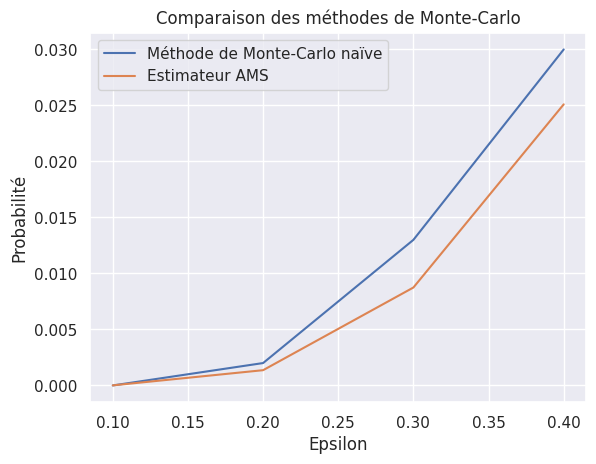

In [19]:
epsilons = [0.1*i for i in range(1, 5)]
hs = [0.1*i for i in range(1, 5)]

naif = [MC_naif(x1+0.1, epsilons[i], hs[i], 1000) for i in range(len(epsilons))]
AMS = [estimateur_AMS(x1+0.1, 1000, hs[i], epsilons[i]) for i in range(len(epsilons))]

plt.plot(epsilons, naif, label='Méthode de Monte-Carlo naïve')
plt.plot(epsilons, AMS, label='Estimateur AMS')
plt.title("Comparaison des méthodes de Monte-Carlo")
plt.xlabel("Epsilon")
plt.ylabel("Probabilité")
plt.legend()
# sauvegarde de l'image
plt.savefig("comparaison.png")
plt.show()

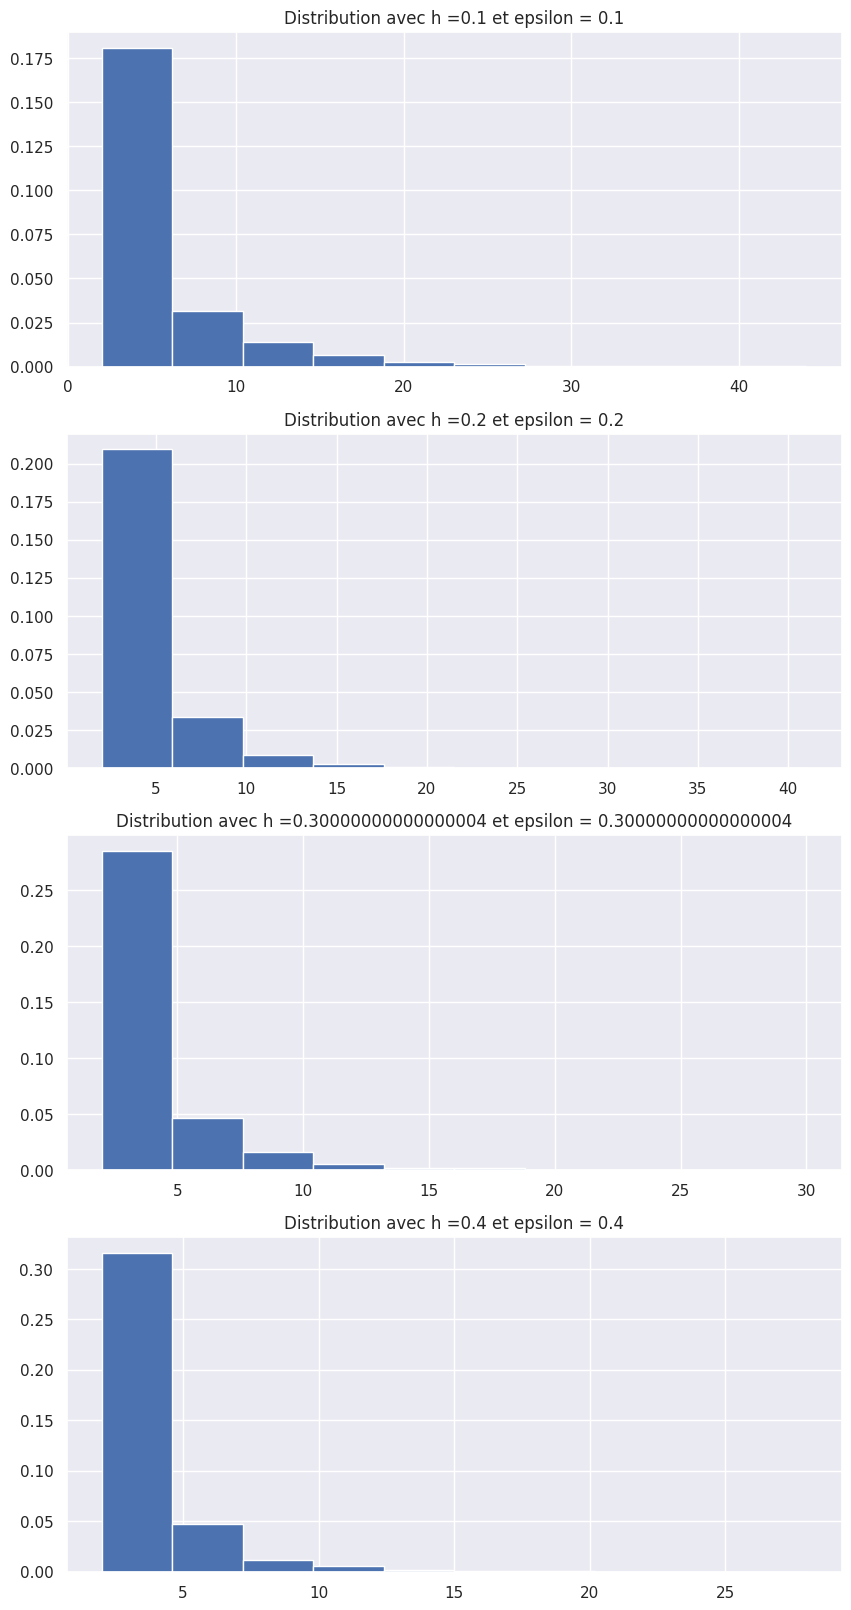

In [20]:
n = 10000

figure, axis = plt.subplots(4)

for i in range(4):
    sigma = np.sqrt(2*hs[i]*epsilons[i])
    trajectoire = [simulation_trajectoire(x1+0.1,hs[i],sigma) for j in range(n)]
    longueurs = [len(trajectoire[j]) for j in range(n)]
    axis[i].hist(longueurs,density =True)
    axis[i].set_title(f'Distribution avec h ={hs[i]} et epsilon = {epsilons[i]}')

figure.set_figheight(20)
figure.set_figwidth(10)
plt.show()

Calcul du temps moyen de transition entre x1 et x2


In [21]:
def simulation_trajectoire_long(X0, h, sigma, K):
    # simulation d'une trajectoire
    Xn = X0
    traj = [X0]
    for i in range(K):
        Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
        traj.append(Xn)
    return np.array(traj)


def time_traj(trajectoire,a,b):
    n = len(trajectoire)
    previous  = True 
    borders_idx = []
    for i in range(n):
        if previous:
            if trajectoire[i]>b and trajectoire[i-1]<b:
                borders_idx.append(i)
                previous = False
        if not previous:
            if trajectoire[i]<a and trajectoire[i-1]>a:
                borders_idx.append(i)
                previous = True

    return borders_idx

43.81818181818182


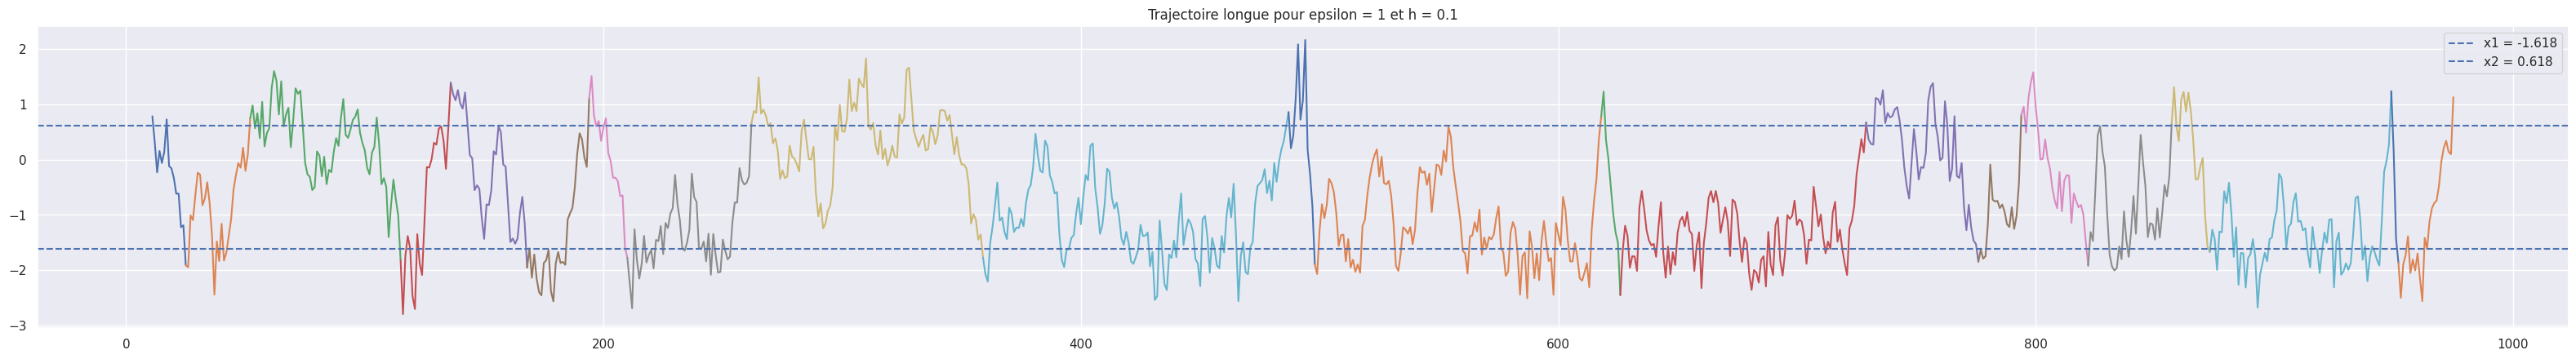

In [206]:
epsilon = 1
h = 0.1
KN = int(1e3)


trajectoire = simulation_trajectoire_long(x1,0.1,np.sqrt(2*h*epsilon),KN)
border_control = time_traj(trajectoire,x1,x2)
transition_times = [border_control[i+1] - border_control[i] for i in range(len(border_control)-1)]
moyenne = np.mean(np.array(transition_times))
trajectoire_transition = [trajectoire[border_control[i]:border_control[i+1]+1] for i in range(len(border_control)-1)]

print(moyenne)

fig, ax = plt.subplots()

for i in range(len(trajectoire_transition)):
    x_axis = np.linspace(border_control[i],border_control[i+1],len(trajectoire_transition[i]))
    ax.plot(x_axis,trajectoire_transition[i])
    
ax.axhline(x1, color='b', linestyle='--', label=f'x1 = {round(x1, 3)}')
ax.axhline(x2, color='b', linestyle='--', label=f'x2 = {round(x2, 3)}')
ax.set_title(f"Trajectoire longue pour epsilon = {epsilon} et h = {h}")
ax.legend()
fig.set_figwidth(40)



/home/smilhey/.virtualenvs/schoolenv/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smilhey/.virtualenvs/schoolenv/lib64/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Evolution du temps de transition moyen entre x1 et x2 en fonction de epsilon')

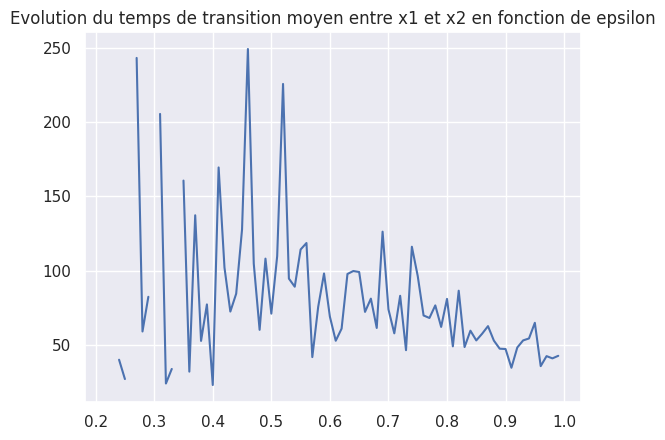

In [23]:
temps_moy = []

epsilons = [0.01*i for i in range(1,100)]
for e in epsilons:
    trajectoire = simulation_trajectoire_long(x1,0.1,np.sqrt(2*0.1*e),int(1e3))
    border_control = time_traj(trajectoire,x1,x2)
    transition_times = [border_control[i+1] - border_control[i] for i in range(len(border_control)-1)]
    temps_moy.append(np.mean(np.array(transition_times)))
                    
plt.plot(epsilons,temps_moy)
plt.title("Evolution du temps de transition moyen entre x1 et x2 en fonction de epsilon")

    

On estime le temps moyen pour aller de x1 à x0 puis de revenir en x1 

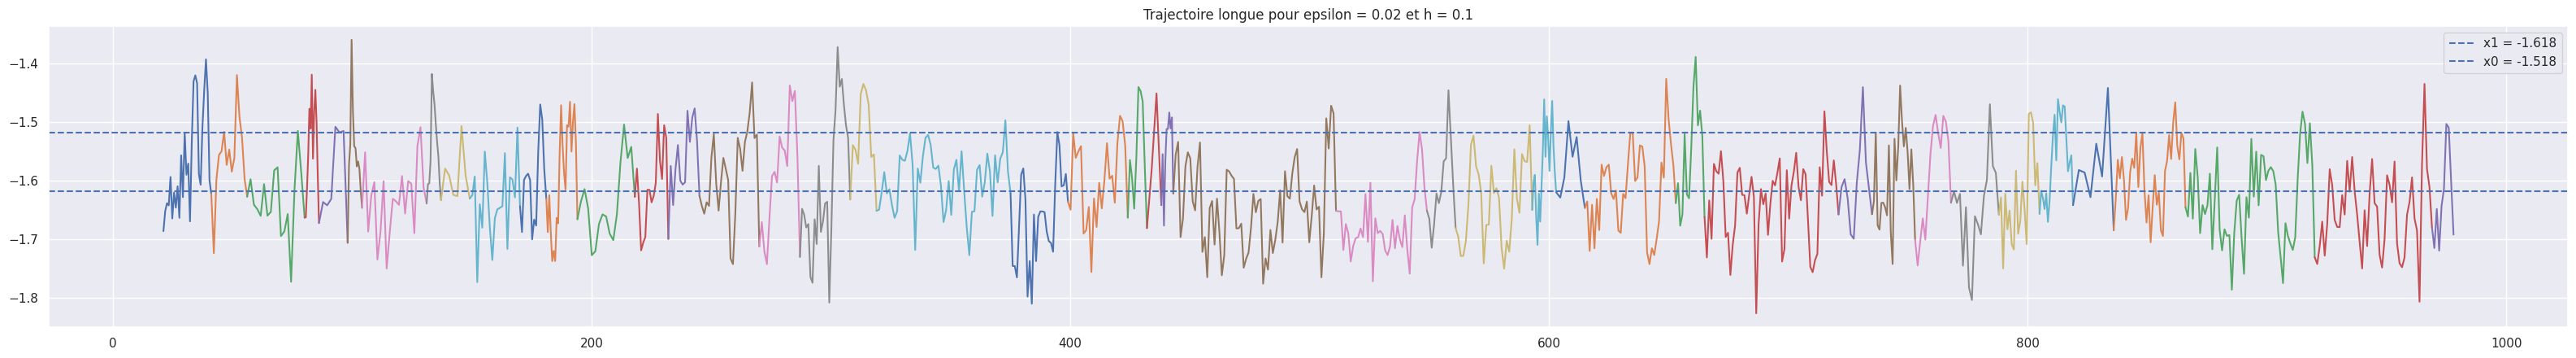

In [96]:
epsilon = 0.02
h = 0.1
KN = 1e3


trajectoire = simulation_trajectoire_long(x1,0.1,np.sqrt(2*h*epsilon),int(KN))
border_control = time_traj(trajectoire,x1,x1+0.1)
transition_times = [border_control[i+2] - border_control[i] for i in range(1,len(border_control)-2,2)]
moyenne = np.mean(np.array(transition_times))
trajectoire_transition = [trajectoire[border_control[i]:border_control[i+2]+1] for i in range(1,len(border_control)-2,2)]



fig, ax = plt.subplots()
j=0
for i in range(len(trajectoire_transition)):
    x_axis = np.linspace(border_control[j],border_control[j+2],len(trajectoire_transition[i]))
    ax.plot(x_axis,trajectoire_transition[i])
    j+=2
    
ax.axhline(x1, color='b', linestyle='--', label=f'x1 = {round(x1, 3)}')
ax.axhline(x1+0.1, color='b', linestyle='--', label=f'x0 = {round(x1+0.1, 3)}')
ax.set_title(f"Trajectoire longue pour epsilon = {epsilon} et h = {h}")
ax.legend()
fig.set_figwidth(40)
plt.savefig("T101.png")



In [201]:
epsilon = 0.02
h = 0.1
KN = int(1e4)


trajectoire = simulation_trajectoire_long(x1,0.1,np.sqrt(2*h*epsilon),int(KN))
border_control = time_traj(trajectoire,x1,x1+0.1)
transition_times = [border_control[i+2] - border_control[i] for i in range(1,len(border_control)-2,2)]
moyenne = np.mean(np.array(transition_times))
trajectoire_transition = [trajectoire[border_control[i]:border_control[i+2]+1] for i in range(1,len(border_control)-2,2)]

print(f"Temps moyen pour passer de x1 à x0 puis revenir en x1 T101 = {moyenne}")

Temps moyen pour passer de x1 à x0 puis revenir en x1 T101 = 22.64090909090909


In [202]:
##  On estime par MC naîf le temps moyen pour aller de x1 à x0

def MC_naif_2(X, epsilon, h, N):
    sigma = np.sqrt(2*epsilon*h)
    time = 0
    for _ in range(N):
        Xn = X
        while Xn <= x0:
            Xn = Xn - Vprime(Xn)*h + sigma*np.random.randn()
            time+=1
    return (time/N)

# Exemple d'une estimation
print("Temps moyen pour passer de x1 à x0 : T10 = {}".format(MC_naif_2(x1, epsilon, h, KN)))

Temps moyen pour passer de x1 à x0 : T10 = 15.1775


In [203]:
## On estime maintenant par AMS le temps pour passer de x0 à x2
def estimateur_AMS(X0, M, h, epsilon, debug=False):
    # variables
    global x2
    trajectoires = []
    I_q = []
    K_q = 0
    sigma = np.sqrt(2*epsilon*h)
    p_estim = 1

    # simulation initiale
    trajectoires = [simulation_trajectoire(X0, h, sigma) for _ in range(M)]
    K_q = K(trajectoires)
    I_q = I(trajectoires, K_q)
    p_estim *= 1 - len(I_q)/M

    q = 0
    while K_q < x2:
        if debug:
            print("Iteration n°{} \t K_q/x2 = {}".format(q, K_q/x2))

        # (i) Branchement
        indices = list(set(range(M)) - set(I_q))
        for m in I_q:
            p = np.random.choice(indices)
            idx = np.where(trajectoires[p] > K_q)[0][0]
            trajectoires[m] = np.concatenate((trajectoires[p][:idx], simulation_trajectoire(trajectoires[p][idx], h, sigma)))

        # (ii) Calcul du niveau
        K_q = K(trajectoires)
        I_q = I(trajectoires, K_q)
        p_estim *= 1 - len(I_q)/M
        longueurs = np.array([len(traj) for traj in trajectoires])

        q += 1

    return (np.mean(longueurs),p_estim)


In [208]:
print(estimateur_AMS(x0, 1000, h, epsilon, debug=False))

TypeError: 'int' object is not callable